# Importing Libraries
Imageio is used for reading the images. The functions are implemented from scratch except for using NumPy's $\texttt{fft}$ for calculating 1D DFT and $\texttt{fftshift}$ function for centering the DFT's. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread
from numpy.fft import fftshift, fft

# Reading Images
Reading the images present. It is assumed that the images are present in the same directory as the notebook.

In [2]:
im_fourier = imread('fourier.png')
im_fourier_trans = imread('fourier_transform.png')
im_peppers = imread('peppers_small.png')

# Floor
An implementation of the floor function

In [3]:
def floor(value):
    # example of how the int function works
    # int(1.3) = 1, int(3.8) = 3
    # int(-0.1) = 0, int(-4.8) = -4
    if value >= 0:
        return int(value)
    else:
        return int(value)-1

# Bilinear Interpolation
Here the Bilinear Interpolation function is defined. Notation is similar as that used in the class.

In [4]:
def bilinear_interpolate(zero_padded_source_image, x, y):
    # shape of the zero padded image
    dx, dy = np.shape(zero_padded_source_image)
    # get the shape of the original image
    dx, dy = dx-2, dy-2
    # +1 as we are taking coordinates with respect to a zero padded image
    x, y = x+1, y+1

    # x', y', a, b as defined in the lecture
    x_prime, y_prime = floor(x), floor(y)
    a = x-x_prime
    b = y-y_prime

    if x_prime >= 0 and x_prime <= dx and y_prime >= 0 and y_prime <= dy:
        # intensity value using bilinear interpolation
        intensity_val = (1-a)*(1-b)*zero_padded_source_image[x_prime, y_prime] \
            + (1-a)*b*zero_padded_source_image[x_prime, y_prime+1] \
            + a*(1-b)*zero_padded_source_image[x_prime+1, y_prime] \
            + a*b*zero_padded_source_image[x_prime+1, y_prime+1]
    else:
        # If the (xs, ys) does not exist in the source image, assign 0
        # for the corresponding (xt, yt) in the target image
        intensity_val = 0

    return intensity_val

# Rotate
A function that takes the required $\theta$ value in degrees and appropriately rotates the source image. Target to source mapping using Bilinear Interpolation is done.

In [5]:
def rotate(source_image, theta):
    # zero padding the image for bilinear interpolation
    x, y = np.shape(source_image)
    image = np.zeros((x+2, y+2))
    image[1:-1, 1:-1] = source_image
    # center of the given image
    center_x, center_y = x/2, y/2
    
    target_image = np.zeros((x, y))

    # convert to radians as NumPy uses radians
    theta *= np.pi/180
    for xt in range(x):
        for yt in range(y):
            # rotate about the center
            # To rotate around a point (x0, y0), we first translate to that point
            x_c, y_c = xt-center_x, yt - center_y
            # Then we apply rotation as we would apply rotation around the origin
            # And then translate back
            xs = np.cos(theta)*x_c - np.sin(theta)*y_c + center_x
            ys = np.cos(theta)*y_c + np.sin(theta)*x_c + center_y
            val = bilinear_interpolate(image, xs, ys)
            target_image[xt, yt] = val
    return target_image

# 2D DFT
Calculate the 2D DFT for a given image. Use the separability property of 2D DFT to break it into row and column transforms. The row and column transforms can be performed using a 1D DFT. Use the optimized $\texttt{fft}$ algorithm to perform the row and column transforms.

In [6]:
def dft_2D(image):
    # get the shape of the image
    m, n = np.shape(image)
    # perform row transform
    row_transform = fft(image, axis=1)
    # perform column transform on the row transformed image
    final_transform = fft(row_transform, axis=0)
    # fftshift to center the resulting DFT for more intuitive visualization
    final_transform = fftshift(final_transform)
    # get the magnitude and phase
    mag = np.abs(final_transform)
    phase = np.zeros_like(final_transform)
    phase[mag!=0] = final_transform[mag!=0]/mag[mag!=0]
    # normalize the magnitude to ensure the transform is unitary
    return mag/(np.sqrt(m*n)), phase

# 2D IDFT
Calculate the 2D IDFT for a given image. Implementation is very similar to the dft_2D function. Use the property that taking DFT of the DFT of an image gives a flipped image to compute the IDFT.

In [7]:
def idft_2D(magnitude, phase, shift_first=True):
    # get the DFT from magnitude and phase
    dft = magnitude*phase
    # get the shape of the image
    m, n = np.shape(dft)
    # shift_first is to handle the case of the rotated DFT
    # shift_first is true in general. As fftshift has been
    # performed on the dft which is the input to this function
    # we need to undo it before calculating the IDFT
    if shift_first:
        dft = fftshift(dft)
    # perform 2D DFT on the DFT
    row_transform = fft(dft, axis=1)
    final_transform = fft(row_transform, axis=0)
    # in the case of rotated DFT, fftshift is not performed from
    # before. So use the DFT as it as and fftshift the final image
    if not shift_first:
        final_transform = fftshift(final_transform)
    # get the magnitude. We do not need the phase as we want the real
    # valued image as the output
    mag = np.abs(final_transform)
    # use the property that taking DFT of the DFT of an image results in
    # a flipped image. undo the flipping effect
    mag = mag[::-1, ::-1]
    # normalize to ensure the transform is unitary
    return mag/(np.sqrt(m*n))

# Phase Dominance of DFT
Check for the fact that the perceptibility of images to humans depends a lot more on the phase component of the DFT compared to the magnitude component. Take two images say $I_{1}$ and $I_{2}$. Compute their DFTs as $F_{1} = |F_{1}|e^{j\Phi_{1}}$ and $F_{2} = |F_{2}|e^{j\Phi_{2}}$ respectively. Swap their magnitudes and phases and get two new images $I_{3}$ and $I_{4}$ such that their DFTs are, respectively, $F_{3} = |F_{1}|e^{j\Phi_{2}}$ and $F_{4} = |F_{2}|e^{j\Phi_{1}}$.

In [8]:
def dft_mixer(im1, im2):
    # get the DFTs of the images
    m1, p1 = dft_2D(im1)
    m2, p2 = dft_2D(im2)
    # get the resulting images by flipping the 
    # magnitudes and phases of the DFTs
    im3 = idft_2D(m1, p2)
    im4 = idft_2D(m2, p1)
    return im3, im4

# Rotation Property of DFT
Compute rotated (such that the image center is the origin) form of 2D DFT as
$$
F(k,l) = \Sigma_{m}\Sigma_{n}f(m,n)e^{-j2\pi\bar{m}^{T}R\bar{k}}
$$

where

$$
\bar{m} = [m\quad n]^{T}
$$

$$
\bar{k} = [\frac{k-\frac{M}{2}}{M}\quad \frac{l-\frac{N}{2}}{N}]^{T}
$$

and

$$R = \begin{bmatrix} cos(\theta) & -sin(\theta)\\ sin(\theta) & cos(\theta) \end{bmatrix}$$

The slightly changed formula for $F$ is to account for the fact that the image may be non square and compute DFT in a way such that the image coordinates at the center are considered the origin.

In [9]:
def rotated_DFT(image, theta):
    # convert theta to radians as NumPy sinusoidal
    # values are calculated with respect to the degree in radians
    theta *= np.pi/180
    # construct the R matrix
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    # get the shape of the image
    x, y = np.shape(image)
    # make a canvas of zeroes of the required shape as the DFT
    # ensure that the data type is complex
    F = np.zeros((x, y), dtype=np.complex)
    # use meshgrid for vectorized operations
    X, Y = np.meshgrid(np.arange(x), np.arange(y))
    # get the image center
    x_c = x//2
    y_c = y//2
    # m_vec to calculate the sum mentioned in the RHS above in one go
    m_vec = np.hstack((X.reshape(-1, 1)-x_c, Y.reshape(-1, 1)-y_c))
    for i in range(x):
        for j in range(y):
            # get the k vector as mentioned
            k_vec = np.array([(i-x_c)/x, (j-y_c)/y])
            k_vec = (R@k_vec)
            vals = m_vec@k_vec
            # perform vectorized multiplication to get all the values and
            # reshape appropriately to get an array of the shape of the image
            vals = (vals.reshape(y, x)).T
            phase = np.exp(-2j*np.pi*(vals))
            # assign the required value
            F[i, j] = np.sum(image*phase)
    # get the magnitude and phase
    mag = np.abs(F)
    phase = F/mag
    # Normalize the magnitude so that the transform is unitary
    return mag/np.sqrt(x*y), phase

# Visualize DFT 
If the DFT magnitude is $M$, plot $log_{10}(M)$ to take care of the fact that the magnitudes vary over a very large range and it is easier to visualize on a log scale. 

In [10]:
def DFT_mag_for_plotting(magnitude):
    return np.log10(magnitude)

# Plotting function
Defining a plotting function for easy plotting of all the cases.

In [11]:
def plotter_two_images(image1, image2, title_1="", title_2=""):
    fig, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(9, 12), constrained_layout=True)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax1.imshow(image1, 'gray')
    ax2.imshow(image2, 'gray')
    ax1.title.set_text(title_1)
    ax2.title.set_text(title_2)
    plt.axis('off')
    plt.show()

# Results
Visualize the results for the different sections. For the rotation property of DFT, the $\theta$ is set to $-10^{\circ}$ and can be changed to see the property for a different angle.  

## DFT of Given Images
DFT Magnitudes of two given images are shown. As expected for natural images, most of the energy lies in a small low frequency region. This is much more so for the $\texttt{fourier.png}$ image compared to the $\texttt{fourier_transform.png}$ image.

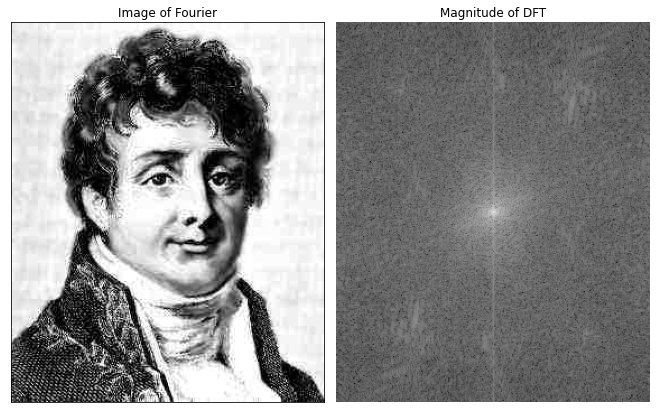

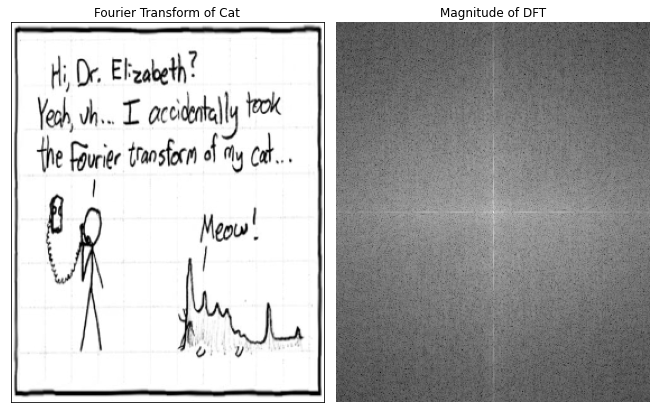

In [12]:
m_four, p_four = dft_2D(im_fourier)
m_four_trans, p_four_trans = dft_2D(im_fourier_trans)
plotter_two_images(im_fourier, DFT_mag_for_plotting(
    m_four), "Image of Fourier", "Magnitude of DFT")
plotter_two_images(im_fourier_trans, DFT_mag_for_plotting(
    m_four_trans), "Fourier Transform of Cat", "Magnitude of DFT")

## Dominance of Phase for Perceptibility
The magnitudes and phases of the DFTs of two images are swapped as mentioned earlier and IDFTs are calculated. The resultant images are shown. As expected, the look of the image is dominated by the phase components.

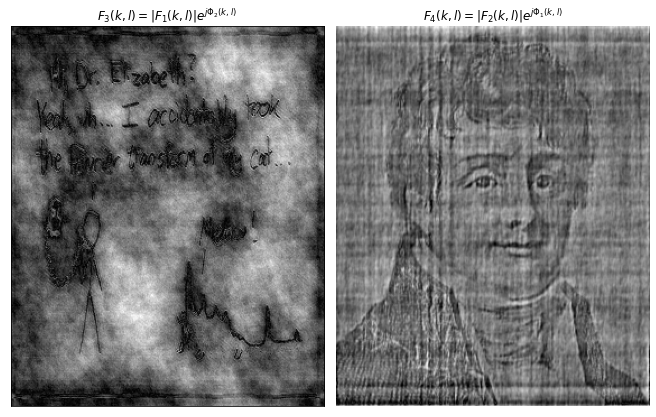

In [13]:
mag_1_phase_2, mag_2_phase_1 = dft_mixer(im_fourier, im_fourier_trans)
plotter_two_images(mag_1_phase_2, mag_2_phase_1,
                   r"$F_{3}(k,l) = \|F_{1}(k, l)\|e^{j\Phi_{2}(k, l)}$", r"$F_{4}(k,l) = \|F_{2}(k, l)\|e^{j\Phi_{1}(k, l)}$")

# Rotated DFT
Rotate the DFT using the formula mentioned earlier and take its IDFT to get the rotated image. Compare it to the result of rotating the image directly in the spatial domain using bilinear interpolation. Also compare the DFT magnitudes and phases resulting from the rotated DFT and taking the DFT of the rotated image.

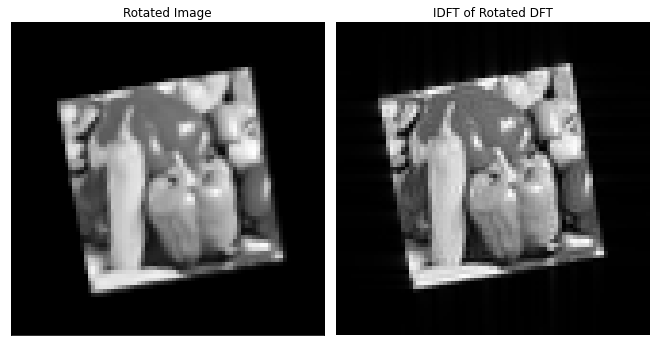

In [14]:
theta = -10
rotated_im_peppers = rotate(im_peppers, theta)
mag_peppers, phase_peppers = rotated_DFT(im_peppers, theta)
rotated_im_peppers_using_dft = idft_2D(
    mag_peppers, phase_peppers, shift_first=False)
plotter_two_images(rotated_im_peppers, rotated_im_peppers_using_dft,
                   "Rotated Image", "IDFT of Rotated DFT")

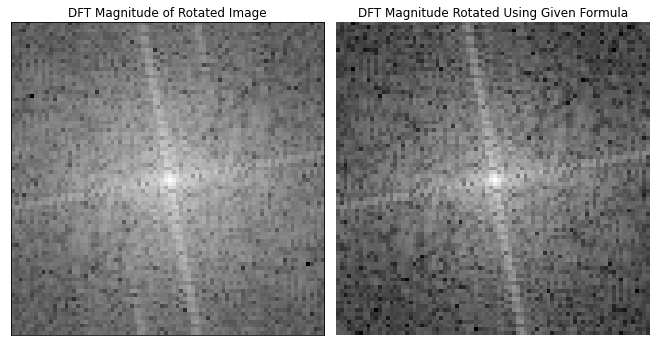

In [15]:
mag_peppers_rotated, phase_peppers_rotated = dft_2D(rotated_im_peppers)
plotter_two_images(DFT_mag_for_plotting(mag_peppers_rotated), DFT_mag_for_plotting(
    mag_peppers), "DFT Magnitude of Rotated Image", "DFT Magnitude Rotated Using Given Formula")

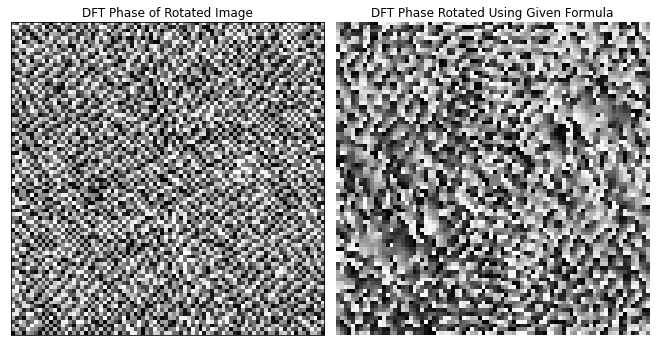

In [16]:
plotter_two_images(np.angle(phase_peppers_rotated), np.angle(phase_peppers),
                   "DFT Phase of Rotated Image", "DFT Phase Rotated Using Given Formula")

# Observations
The following observations can be made
- Most of the energy of the images is concentrated in a small region around the origin. This is true for most natural images.
- The DFT magnitude of $\texttt{fourier_transform.png}$ contains a distinct horizontal line, which is not present in the DFT magnitude of $\texttt{fourier.png}$. This can be attributed to the fact that the former contains a lot of vertical edges in the spatial domain, which give rise to a horizontal line in the DFT. Since not a lot of vertical edges are present in the spatial domain of $\texttt{fourier.png}$, we do not see such a horizontal line in its DFT magnitude.
- On calculating the DFTs for two images, swapping their magnitudes and phases, and then taking their IDFT, the resulting images look much closer to the image whose phase component they contain compared to the magnitude component. 
- Rotating an image in the spatial domain or rotating the DFT and then taking its IDFT results in almost identical looking images. We say almost as the spatial domain rotation uses bilinear interpolation, resulting in a smoother image than that obtained from rotating the DFT and taking its IDFT.
- Comparing the magnitudes of the rotated DFT and taking DFT after rotating the image in the spatial domain, we see almost similar results except some small deviations at higher frequencies.
- The phases look markedly different. It is hard to interpret, however, as the images look very similar in the spatial domain.